# Лабораторная №4. Снижение размерности признакового пространства методом главных факторов.

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as ss
import seaborn as sns

from math import  sin, cos, pi 
from statsmodels.formula.api import ols
from scipy.stats import chi2
from numpy import arange

### Считывание данных

In [2]:
#features =["X7", "X15", "X17", "X23", "X27"] 
features =["X6", "X16", "X26", "X31", "X39"] 
f_len = len (features)
unclr_data = pd.read_excel (r'C:\Games\Ekonometrika\data_for_3_and_4.xlsx').loc[:,features]
#unclr_data = pd.read_excel (r'C:\Games\Ekonometrika\data_for_3_and_4_sok.xlsx').loc[:,features]
unclr_data.head()

,X6,X16,X26,X31,X39
Абдулинский,20.8,58.5,69,15626,0.1
Адамовский,12.4,93.0,180,23410,1.4
Акбулакский,11.9,39.8,224,9855,0.7
Александровский,13.6,55.0,116,4881,0.2
Асекеевский,17.2,63.5,172,15466,5.3


In [3]:
unsc_data = unclr_data[unclr_data!='-'].dropna().astype('float64') # для которых нет значений, удаляем, потом стандартизуем
index = unsc_data.index #записываем в переменную index названия строк исходной матрицы
columns = unsc_data.columns #записываем в переменную columns названия столбцов исходной матрицы

index = unsc_data.index
columns = unsc_data.columns

scaled = (unsc_data - unsc_data.mean(axis=0))/unsc_data.std()
data = pd.DataFrame(scaled, columns=columns, index=index) 

data.head()

,X6,X16,X26,X31,X39
Абдулинский,2.134439,-0.704855,-0.509842,-0.254979,-0.506938
Адамовский,-1.115374,0.529669,-0.066461,-0.059897,-0.464704
Акбулакский,-1.308815,-1.374003,0.109294,-0.399611,-0.487445
Александровский,-0.651115,-0.830097,-0.322104,-0.524269,-0.503689
Асекеевский,0.741662,-0.525938,-0.098416,-0.258989,-0.338005


### Рассчитаем оценку корреляционной матрицы и проверим ее на значимость.

In [4]:
correlations = data.corr()
correlations

,X6,X16,X26,X31,X39
X6,1.000000,-0.073048,-0.160053,-0.109575,0.034846
X16,-0.073048,1.000000,0.450651,0.480604,0.176877
X26,-0.160053,0.450651,1.000000,0.159392,0.480870
X31,-0.109575,0.480604,0.159392,1.000000,0.046086
X39,0.034846,0.176877,0.480870,0.046086,1.000000


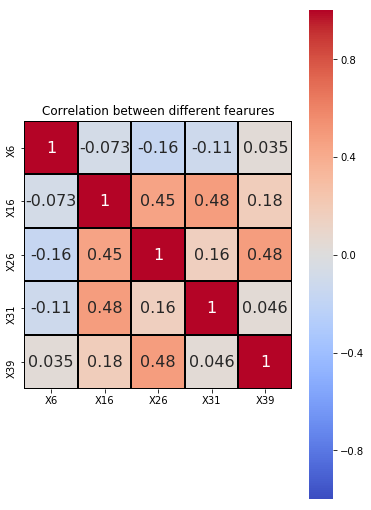

In [5]:
plt.figure(figsize=(6,9))
sns.heatmap(correlations, vmax=1,vmin=-1, center=0, square=True,annot=True,cmap='coolwarm',annot_kws={"size": 16}, 
            linewidths=1, linecolor='black')
plt.title('Correlation between different fearures')
plt.show()

Далее согласно алгоритму, предполагая, что выборка извлечена из нормально распределенной генеральной совокупности, на уровне значимости α = 0,05 проверим гипотезу о незначимости корреляционной матрицы.

In [6]:
def chi_2(n,k,R):
    return -(n-1/6*(2*k+5))*math.log(np.linalg.det(R), math.e)

chi_2_crt=chi_2(data.shape[0],data.shape[1],correlations)
print('Наблюдаемое значение составило',chi_2_crt)
p_value=chi2.sf(chi_2_crt, data.shape[1]*(data.shape[1]-1)/2)
print ('Значение p-value равно {}'.format(p_value))
if p_value>0.05:
    print('Принимаем гипотезу, матрица парных коэффициентов корреляции незначима')
else:
    print('Отвергаем гипотезу, матрица парных коэффициентов корреляции значима')

Наблюдаемое значение составило 36.16939247904436
Значение p-value равно 7.87158807955768e-05
Отвергаем гипотезу, матрица парных коэффициентов корреляции значима


# Снижение размерности методом главных компонент.

## Рассчитаем оценки собственных чисел корреляционной матрицы.

In [7]:
uns_eigenvalues,eigenvectors=np.linalg.eig(correlations)
couple_lst=[]
for i in range(len(uns_eigenvalues)):
    couple_lst.append((uns_eigenvalues[i],eigenvectors[:,i]))
    
from operator import itemgetter
couple_lst = sorted(couple_lst, key = itemgetter(0),reverse=True)
#список со значениями оценок собственных чисел (eigenvalues), расположенных по убыванию
eigenvalues=sorted(uns_eigenvalues,reverse=True)

In [8]:
pd.DataFrame(eigenvalues, index=list(range(1,f_len+1)), columns = ['eigenvalues'])

,eigenvalues
1,1.956367
2,1.146613
3,0.973859
4,0.561517
5,0.361644


## Доверительные интервалы для собственных значений

С вероятностью γ=0,95 построим доверительные интервалы для собственных чисел матрицы парных коэффициентов корреляции.
Доверительный интервал для i-ого собственного числа λi при большом объеме выборки имеет вид:

$$ \frac {\hat \lambda_i}{1 +  u_{\frac {1+\gamma} {2}} \sqrt {\frac {2}{n-1}} } < \lambda_i < \frac {\hat \lambda_i}{1 -  u_{\frac {1+\gamma} {2}} \sqrt {\frac {2}{n-1}} } $$ 

где $ u_{\frac {1+\gamma} {2}} $ – квантиль уровня $ \frac {1+\gamma}{2} $ стандартного нормального распределения
<br>
n – объем выборки.

In [9]:
def eigenval_left(l,n):
    return l/(1+ss.norm.ppf(0.975)*math.sqrt(2/(n-1))) #находим нижнюю границу интервала

def eigenval_right(l,n):
    return l/(1-ss.norm.ppf(0.975)*math.sqrt(2/(n-1))) #находим верхнюю границу интервала

conf_interval=np.empty((5, 3)) # создание матрицы для каждого из значений интервала и соответствующего ему собственного числа
for i in range(conf_interval.shape[0]):
    conf_interval[i,0]=eigenval_left(eigenvalues[i],data.shape[0])
    conf_interval[i,1]=eigenvalues[i]
    conf_interval[i,2]=eigenval_right(eigenvalues[i],data.shape[0])
    
conf_interval_df=pd.DataFrame(
    conf_interval,
    columns=['Нижняя граница','Собственное значение','Верхняя граница'])
conf_interval_df

,Нижняя граница,Собственное значение,Верхняя граница
0,1.388794,1.956367,3.308478
1,0.813962,1.146613,1.939076
2,0.691327,0.973859,1.646926
3,0.398612,0.561517,0.949600
4,0.256725,0.361644,0.611589


Так как оценки собственных чисел не попадают в доверительные интервалы других собственных чисел, то нет оснований заподозрить кратность собственных чисел.

## Определение количества ГК

Рассчтаем вклад главных компонент в суммарную дисперсию исходных признаков.

In [10]:
dispersion=np.zeros(len(eigenvalues))
for i in range(dispersion.shape[0]):
    dispersion[i]=eigenvalues[i]/uns_eigenvalues.sum()

In [11]:
cumlt_dispersion = np.zeros(f_len)
cur=0
for i in range(len(features)):
    cur=cur+dispersion[i]
    cumlt_dispersion[i]=cur

In [12]:
cumlt=np.zeros(f_len)
cur=0
for i in range(len(features)):
    cur=cur+eigenvalues[i]
    cumlt[i]=cur

In [13]:
d=np.array([eigenvalues,dispersion,cumlt,cumlt_dispersion]).T
s=pd.DataFrame(
    data=d,
    columns=['eig','variance','cumlt_eig','cumlt_variance'])
s

,eig,variance,cumlt_eig,cumlt_variance
0,1.956367,0.391273,1.956367,0.391273
1,1.146613,0.229323,3.102980,0.620596
2,0.973859,0.194772,4.076839,0.815368
3,0.561517,0.112303,4.638356,0.927671
4,0.361644,0.072329,5.000000,1.000000


In [14]:
#нижняя граница уровня информативности
low_inf = (conf_interval[0,0] + conf_interval[1,0])*100/5
print ('Нижняя граница уровня информативности:',"%5.2f"%(low_inf)+'%')

Нижняя граница уровня информативности: 44.06%


### Критерий Кайзера

Посмотрим, сколько главных компонент предлагает взять критерий Кайзера.

In [15]:
print(('Критерий Кайзера предлагает {} ГК.').format(len(s.eig[s.eig > 1])))

Критерий Кайзера предлагает 2 ГК.


### Критерий каменистой осыпи

Построим график собственных чисел корреляционной матрицы.

In [16]:
sum_lmbd=uns_eigenvalues.sum()
dft = pd.DataFrame([])
dft['y'] = eigenvalues #собственные значения в порядке убывания
dft['x'] = list(range(1,f_len+1))
dft['Tot_var'] = (dft['y']/sum_lmbd).apply(lambda x: round(x * 100, 2)).apply(str) + '%' #относительный вклад каждой 
#главной компоненты в суммарную дисперсию

In [17]:
dft

,y,x,Tot_var
0,1.956367,1,39.13%
1,1.146613,2,22.93%
2,0.973859,3,19.48%
3,0.561517,4,11.23%
4,0.361644,5,7.23%


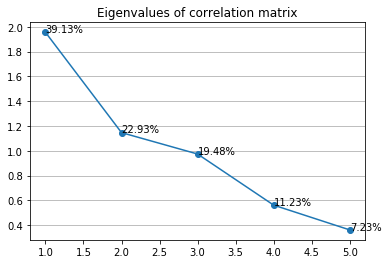

In [18]:
#plt.figure(figsize=(9,6))
plt.plot(dft['x'], dft['y'], marker='o')
ax = plt.gca()
dft.apply(lambda x: ax.annotate(x['Tot_var'], (x['x'], x['y'])), axis=1);
plt.title('Eigenvalues of correlation matrix')
plt.grid(axis='y')
plt.show()

Выбираем количество главных компонент на основе критериев

In [19]:
pc = 3

## Матрица U

Матрица коэффициентов линейного преобразования имеет вид:

In [20]:
u=np.empty((f_len,f_len))
for i in range(f_len):
    u[i]=couple_lst[i][1] #достаем главные компоненты(собственные векторы корреляционной матрицы) из матрицы couple_list
    
#pd.DataFrame(u)

In [21]:
df_u=pd.DataFrame(
    data=u,
    index=['Factor_' + str(i + 1) for i in range(f_len)],
    columns=features)
df_u # eigenvectors of correlation matrix
# ВНИМАНИЕ !!!!!
#Она не сходится со статистикой !!! Но правильная именно в питоне ( в статистике матрица не нормирована, см. методичку) !!!

,X6,X16,X26,X31,X39
Factor_1,0.170584,-0.562766,-0.565239,-0.415934,-0.402117
Factor_2,-0.348755,0.255707,-0.315968,0.555395,-0.636148
Factor_3,0.897828,0.252420,-0.185801,0.307876,-0.029672
Factor_4,-0.121949,-0.463633,-0.383176,0.558308,0.558249
Factor_5,-0.168242,0.582440,-0.631920,-0.334723,0.347988


Главные компоненты связаны с центрировано-нормированными исходными признаками следующими линейными комбинациями:

In [22]:
for i in range(0,pc):
    print(('Z{:1} = '+'{:2.3f}*X{:1} + '*4+'{:2.3f}*X{:1}').format(i+1,u[i][0],1,u[i][1],2,u[i][2],3,u[i][3],4,u[i][4],5))

Z1 = 0.171*X1 + -0.563*X2 + -0.565*X3 + -0.416*X4 + -0.402*X5
Z2 = -0.349*X1 + 0.256*X2 + -0.316*X3 + 0.555*X4 + -0.636*X5
Z3 = 0.898*X1 + 0.252*X2 + -0.186*X3 + 0.308*X4 + -0.030*X5


## Матрица нагрузок А

Рассчитаем матрицу нагрузок.

In [23]:
#матрица нагрузок
lmbd = np.zeros((f_len,f_len))
for i in range(f_len):
    lmbd[i][i]= math.sqrt(eigenvalues[i])
            
A = np.dot(u.T, lmbd)
df_A = pd.DataFrame(data=A,columns=['Factor_' + str(i + 1) for i in range(f_len)],index=features)
df_A

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
X6,0.238597,-0.373447,0.886015,-0.091382,-0.101175
X16,-0.787142,0.273811,0.249099,-0.347421,0.350261
X26,-0.790601,-0.338339,-0.183357,-0.287130,-0.380017
X31,-0.581768,0.594718,0.303825,0.418365,-0.201292
X39,-0.562442,-0.681187,-0.029282,0.418320,0.209269


In [24]:
# Могут не совпасть отдельные столбики со Statistica, так как собственные вектора берутся с точностью до знака
# Если очень хочется подогнать, можно написать:
#df_A['Factor_1'] *= -1  # если не совпал первый столбик
#df_A['Factor_2'] *= -1  # если не совпал второй столбик
#df_A['Factor_3'] *= -1  # если не совпал третий столбик
#df_A['Factor_4'] *= -1  #если не совпал четвертый столбик
#df_A['Factor_5'] *= -1  #если не совпал пятый столбик
#df_A#проверить, сходится ли теперь

Так как размерность признакового пространства снижена до двух, то матрица факторных нагрузок имеет размерность 5х2.

In [25]:
df_A_cut = pd.DataFrame(data=A[:,:pc],columns=['Factor_' + str(i) for i in range(1,pc+1)],index=features)
df_A_cut

,Factor_1,Factor_2,Factor_3
X6,0.238597,-0.373447,0.886015
X16,-0.787142,0.273811,0.249099
X26,-0.790601,-0.338339,-0.183357
X31,-0.581768,0.594718,0.303825
X39,-0.562442,-0.681187,-0.029282


Получим расположение признаков в пространстве первых двух главных компонент.
Если вы вдруг взяли 3 главные компоненты, то тут можно получать сравненение только по двум координатам,
меняя в 'Factor_' цифры
Трехмерное изображение не предусмотрено

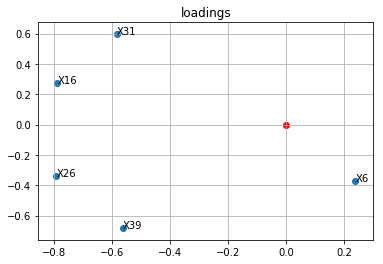

In [26]:
#plt.figure(figsize=(9,6))
plt.scatter(df_A_cut['Factor_1'], df_A_cut['Factor_2'])
plt.scatter (0,0,c = 'r')
for i in features:
    plt.annotate('{}'.format(i), xy=(df_A_cut['Factor_1'][i], df_A_cut['Factor_2'][i]))
plt.title('loadings')
plt.grid()
plt.show()

Центрировано-нормированные исходные признаки связаны с центрировано-нормированными главными компонентами следующими выражениями:

In [27]:
for i in range(0,f_len):
    print(('X{:1} = '+'{:2.3f}*F{:1} + {:2.3f}*F{:1} + {:2.3f}*F{:1}').format(i+1,A[i][0],1,A[i][1],2,A[i][2],3))

X1 = 0.239*F1 + -0.373*F2 + 0.886*F3
X2 = -0.787*F1 + 0.274*F2 + 0.249*F3
X3 = -0.791*F1 + -0.338*F2 + -0.183*F3
X4 = -0.582*F1 + 0.595*F2 + 0.304*F3
X5 = -0.562*F1 + -0.681*F2 + -0.029*F3


## Расчет индивидуальных значений (матрица F)

Рассчитаем матрицу индивидуальных значений центрировано-нормированных главных компонент.

In [28]:
F=np.dot(np.dot(np.linalg.inv(np.dot(A[:,:pc].T,A[:,:pc])),A[:,:pc].T),data.T)
df_F = pd.DataFrame(data=F.T, columns=['Factor'+str(i) for i in range(1,pc+1)], index=data.index).head()
df_F

,Factor1,Factor2,Factor3
Абдулинский,0.971513,-0.544139,1.793303
Адамовский,-0.170873,0.754375,-0.871484
Акбулакский,0.608009,0.148230,-1.672799
Александровский,0.685457,0.136194,-0.892481
Асекеевский,0.516025,-0.271636,0.488128


# Снижение размерности признакового пространства методом главных факторов

## Оценки общностей и ОЦЕНКА редуцированной матрицы

### Оценки общностей

Оценками общностей будут служить квадраты оценок множественных коэффициентов корреляции.

In [29]:
communalities=[]
for variable in features:
    communalities.append(ols(formula="{} ~ {}".format(variable, ' + '.join(set(features)-set([variable]))),
                             data=data).fit().rsquared)

In [30]:
pd.DataFrame(communalities,index = features,columns = ['Communalities']) # это те самые множественные коэффициенты корреляции, которые являются оценками общностей

,Communalities
X6,0.050726
X16,0.377020
X26,0.394488
X31,0.242256
X39,0.246047


### Оценка матрицы Rh

На основе оценки матрицы парных коэффициентов корреляции и оценок общностей можно составить ОЦЕНКУ редуцированной матрицы R<sub><small>h</small></sub>.

In [31]:
Rh_eval = np.empty((f_len,f_len)) # оценка матрицы Rh - она как R, но на диагоналях оценки общностей
for i in range (f_len):
    for j in range (f_len):
        if i==j:
            Rh_eval[i][j] = communalities[i]
        else:
            Rh_eval[i][j] = correlations.values [i][j]
            
pd.DataFrame(Rh_eval, index=features, columns=features)

,X6,X16,X26,X31,X39
X6,0.050726,-0.073048,-0.160053,-0.109575,0.034846
X16,-0.073048,0.377020,0.450651,0.480604,0.176877
X26,-0.160053,0.450651,0.394488,0.159392,0.480870
X31,-0.109575,0.480604,0.159392,0.242256,0.046086
X39,0.034846,0.176877,0.480870,0.046086,0.246047


## Выбор количества факторов

Рассчитаем оценку собственных чисел оцененной матрицы R<sub><small>h</small></sub>.

In [32]:
uns_eigenvalues_Rh_eval,eigenvectors_Rh_eval=np.linalg.eig(Rh_eval)
couple_lst=[]
for i in range(len(uns_eigenvalues_Rh_eval)): # список по убыванию сз с соответствующими св
    couple_lst.append((uns_eigenvalues_Rh_eval[i],eigenvectors_Rh_eval[:,i]))
    
from operator import itemgetter
couple_lst = sorted(couple_lst, key = itemgetter(0),reverse=True)
#значениями оценок собственных чисел (eigenvalues), расположенных по убыванию
eigenvalues_Rh_eval=sorted(uns_eigenvalues_Rh_eval,reverse=True)


Выведем собственные значения и соответсвующие им собственые вектора оцененной матрицы R<sub><small>h</small></sub>.

In [33]:
couple_lst

[(1.289822425714057,
  array([ 0.13394899, -0.58028438, -0.59064323, -0.38695547, -0.38305841])),
 (0.41298588899913274,
  array([-0.13745812,  0.36277188, -0.38652728,  0.58783333, -0.5954414 ])),
 (0.06668779415330427,
  array([ 0.91010053,  0.21303234, -0.23975592,  0.14513126,  0.21860528])),
 (-0.1514456931855765,
  array([-0.19642103, -0.4726166 , -0.31616235,  0.58682688,  0.54196672])),
 (-0.3075139671792069,
  array([-0.31032038,  0.5127547 , -0.58676717, -0.37321384,  0.39648405]))]

### Сравнение общности с суммой лямбд

In [34]:
print('Суммарная общность: ', np.trace(Rh_eval))
print('Сумма оценок первых двух собственных чисел редуцированной матрицы:', eigenvalues_Rh_eval[0]+eigenvalues_Rh_eval[1])
if  np.trace(Rh_eval) < eigenvalues_Rh_eval[0]+eigenvalues_Rh_eval[1]:
    print('Размерность признакового пространства можно снизить до двух общих факторов.')
else:
    print ('До двух факторов снизить нельзя')

Суммарная общность:  1.3105364485017097
Сумма оценок первых двух собственных чисел редуцированной матрицы: 1.7028083147131896
Размерность признакового пространства можно снизить до двух общих факторов.


### Критерий каменистой осыпи

In [35]:
dft = pd.DataFrame([])
eigenvalues_pos=[]
for i in range (len(eigenvalues_Rh_eval)):
    if eigenvalues_Rh_eval[i] >= 0:
        eigenvalues_pos.append(eigenvalues_Rh_eval[i])
dft['y'] = eigenvalues_pos
dft['x'] = list (range(len(eigenvalues_pos)))
dft['Tot_var'] = (dft['y']/f_len).apply(lambda x: round(x * 100, 2)).apply(str) + '%'
dft

,y,x,Tot_var
0,1.289822,0,25.8%
1,0.412986,1,8.26%
2,0.066688,2,1.33%


Построим график собственных чисел (положительных).

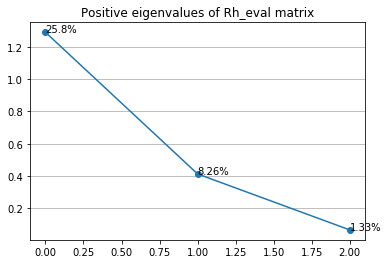

In [36]:
plt.figure(figsize=(6,4))
plt.plot(dft['x'], dft['y'], marker='o')
ax = plt.gca()
dft.apply(lambda x: ax.annotate(x['Tot_var'], (x['x'], x['y'])), axis=1)
plt.title('Positive eigenvalues of Rh_eval matrix')
plt.grid(axis='y')
plt.show()

### Критерий Кайзера

Посмотрим, сколько факторов предлагает брать критерий Кайзера.

In [37]:
print('Критерий Кайзера предлагает {} фактор(-а/ов).'
      .format(len(uns_eigenvalues_Rh_eval[uns_eigenvalues_Rh_eval > 1])))

Критерий Кайзера предлагает 1 фактор(-а/ов).


### Итоговое решение (на самом деле придется всегда брать 2)

Установим число факторов равное двум.

In [38]:
fact = 2

## матрица U

Рассчитаем матрицу U.

In [39]:
U = np.empty ((fact,f_len)) # матрица U (у неё по строкам собств. вектора, соотв. положительным значениям РЕДУЦИРОВАННОЙ МАТРИЦЫ (уточнить у Домашовой))
for i in range(fact):
    U[i]=couple_lst[i][1]
    
df_U=pd.DataFrame( # обертка в датафрейм
    data=U,
    index=['Factor_' + str(i + 1) for i in range(fact)],
    columns=features)
df_U

,X6,X16,X26,X31,X39
Factor_1,0.133949,-0.580284,-0.590643,-0.386955,-0.383058
Factor_2,-0.137458,0.362772,-0.386527,0.587833,-0.595441


### Матрица нагрузок A

Рассчитаем матрицу нагрузок.

In [40]:
sqrt_l=np.eye(fact)
for i in range(fact):
    sqrt_l[i][i]=math.sqrt(eigenvalues_Rh_eval[i])  
A=np.dot(U.T,sqrt_l)
df_A = pd.DataFrame(
    data=A,
    columns=['Factor_' + str(i + 1) for i in range(fact)],
    index=features)
df_A # на этом этапе матрица может не совпасть со statistica во всех знаках 1-ого или 2-ого столбца (или в обоих)
# Это НЕ ОШИБКА, так как собственные вектора матрицы U (а по ней по сути и строится А) берутся с точностью до знака

,Factor_1,Factor_2
X6,0.152126,-0.088336
X16,-0.659031,0.233132
X26,-0.670796,-0.248398
X31,-0.439467,0.377765
X39,-0.435041,-0.382654


Если очень хочется подогнать под statistica, то можно написать:

In [41]:
#df_A['Factor_1'] *= -1  # если не совпал первый столбец

In [42]:
#df_A['Factor_2'] *= -1 #   если не совпал второй столбец

In [43]:
#df_A # проверить, совпадает ли теперь

Построим расположение исходных признаков на плоскости, образованной двумя главными факторами.

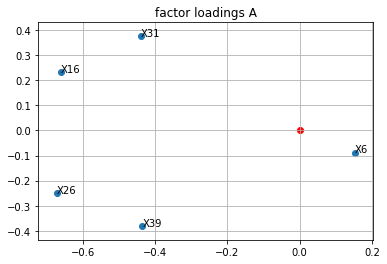

In [44]:
plt.scatter(df_A['Factor_1'],df_A['Factor_2'])
plt.scatter (0,0,c = 'r') # чтобы было видно, относительно чего потом будем поворачивать
plt.grid()
plt.title ('factor loadings A')
for variable in features :
    plt.annotate('{}'.format(variable),xy = (df_A['Factor_1'][variable],df_A['Factor_2'][variable]))

## Вращение факторов

In [45]:
_ = \
'''
задумка, чтобы максимально подогнать под статистику

Будем осуществлять повороты на углы от 0 до pi/2 с очень маленьким шагом и считать квартимакс(варимакс) 
для каждого угла
По максимальному квартимаксу(варимаксу) отбираем соответствующую матрицу B
'''

In [46]:
def quartimax (X): # ФУНКЦИИ ДЛЯ ВЫБОРА И  РАСЧЕТА КРИТЕРИЯ
    value = 0
    m = X.shape[1]
    for row in X:
        value += (sum (row**4) - (sum(row**2))**2)/m**2
    return value

def varimax (X) :
    value = 0
    k = X.shape[0]
    for row in X.T:
        value += (k*sum(row**4) - sum(row**2)**2)/k**2
    return value
    
def criteria (method,X):
    if method == 'varimax':
        return varimax(X)
    elif method == 'quartimax':
        return quartimax (X)
    else :
        print ('wrong input')

In [47]:
rad_column = [] # это список, в который будут складываться углы в радианах
grad_column=[] # это список, в который будут складывать углы в градусах

criteria_column = [] # это список, в который будут складываться квартимаксы
dict_for_B = {} # это словарь, где ключами будут квартимаксы, а значениями - матрицы

for alpha in arange (0,pi/2,0.0001): # Проходим от 0 до pi/2 с шагом 0.0001
    
    rad_column.append(alpha)
    grad_column.append(alpha*180/pi)
    
    grad = alpha
    T = [[cos(grad),sin(grad)],
         [-sin(grad),cos(grad)]]
    B = np.dot (A,T)
    dict_for_B[criteria('quartimax',B)] = B # здесь пишем метод, который мы хотим
    criteria_column.append (criteria('quartimax',B)) # и здесь тоже

In [48]:
df_rotation = pd.DataFrame([]) # дата фрейм, в который мы положим заполненные списки
df_rotation['rad'] = rad_column
df_rotation['grad'] = grad_column
df_rotation ['criteria'] = criteria_column
#df_rotation # это по сути и есть та самая сетка

### Максимальное значение критерия

In [49]:
criteria_best = df_rotation ['criteria'].max() # ищем максимальное значение критерия
criteria_best

-0.03737524878647298

### Лучший угол для вращения

In [50]:
rad_best = df_rotation.loc[df_rotation['criteria'].idxmax(),'rad']# вывод лучшего угла
grad_best = df_rotation.loc [df_rotation['criteria'].idxmax(),'grad']
print ('Лучший угол для вращения :{:.3f} радиан или {:.3f} градусов'.format (rad_best,grad_best)) 

Лучший угол для вращения :0.823 радиан или 47.172 градусов


### Матрица B 

Весовые коэффициенты факторов после вращения:

In [51]:
B = dict_for_B [criteria_best] # вывод лучшей матрицы
df_B = pd.DataFrame(data=B, columns=['Factor_' + str(i + 1) for i in range(fact)], index=features)
df_B

,Factor_1,Factor_2
X6,0.168201,0.051517
X16,-0.618990,-0.324845
X26,-0.273837,-0.660819
X31,-0.575802,-0.065495
X39,-0.015107,-0.579186


In [52]:
_ = \
'''
Результат может не сходиться со statistica (могут не совпадать все знаки в столбце(-цах), 
а также в statistica может быть другой порядок столбцов (или всё вместе))
Это НЕ ОШИБКА, так как данное несоответствие обуславливается тем, что: 
 a) Могло быть несоответствие в матрице A и его не поправляли
 б) Угол поворота в statistica был не в интервале [0;pi/2]
Если очень хочется подогнать под статистику,то:
1)подгоните матрицу A (если надо) 
2)попробуйте поменять промежуток в цикле на :

2a)[pi/2 ; pi]  в случае, если столбцы  поменялись местами и не совпадает знак ПЕРВОГО столбца в полученной матрице
2б) [pi;3*pi/2] в случае если столбцы на месте, но отличаются АБСОЛЮТНО ВСЕ ЗНАКИ
2в) [3*pi/2;2*pi] в случае если столбцы поменялись местами и не совпадает знак ВТОРОГО столбца в полученной матрице

Если у вас матрица B не сходится со статистикой и при этом не подходит ни одному из случаев, то вы либо
не подогнали A, либо накосячили ещё где-то )))

'''

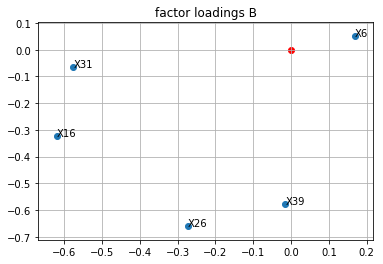

In [53]:
plt.scatter(df_B['Factor_1'],df_B['Factor_2'])
plt.scatter (0,0,c= 'r')
plt.grid()
plt.title ('factor loadings B')
for variable in features :
    plt.annotate('{}'.format(variable),xy = (df_B['Factor_1'][variable],df_B['Factor_2'][variable]))
    #график может не совпасть со statistica по описанным ранее причинам

### Теперь сравниваем два графика (две матрицы) A и B и решаем, помогло ли вращение.Если НЕ помогло, то следует снять комментарий и прораннить следующую строчку:

In [54]:
#B = A

## Rh, D2, значения характерностей

Рассчитаем характерности. Для этого нам необходимо получить матрицы R<sub><small>h</small></sub> (оценка редуцированной матрицы) и D<sup>2</sup> (оценка остаточной матрицы парных коэффициентов корреляции).

In [55]:
Rh_real = np.dot(B,B.T)
pd.DataFrame(Rh_real,index = features,columns = features) # в statistica это reproduced corr

,X6,X16,X26,X31,X39
X6,0.030946,-0.120850,-0.080103,-0.100225,-0.032379
X16,-0.120850,0.488672,0.384166,0.377691,0.197497
X26,-0.080103,0.384166,0.511668,0.200956,0.386874
X31,-0.100225,0.377691,0.200956,0.335837,0.046632
X39,-0.032379,0.197497,0.386874,0.046632,0.335685


In [56]:
D2 = correlations.values - Rh_real
pd.DataFrame(D2,index = features,columns = features) # в statistica это residual corr

,X6,X16,X26,X31,X39
X6,0.969054,0.047802,-0.079950,-0.009350,0.067225
X16,0.047802,0.511328,0.066485,0.102912,-0.020620
X26,-0.079950,0.066485,0.488332,-0.041565,0.093996
X31,-0.009350,0.102912,-0.041565,0.664163,-0.000546
X39,0.067225,-0.020620,0.093996,-0.000546,0.664315


In [57]:
charact =[]
for i in range(D2.shape[0]):
    charact.append (math.sqrt(D2[i][i]))
    
charact

[0.9844055657770608,
 0.7150718732567741,
 0.6988074266658403,
 0.8149617039824844,
 0.8150553262875072]

In [58]:
for i in range(0,f_len):
    print('X{} = {:.3f}*F{} + {:.3f}*F{} + {:.3f}*D{}'.format(i+1,B[i,0],1,B[i,1],2,charact[i],i+1))

X1 = 0.168*F1 + 0.052*F2 + 0.984*D1
X2 = -0.619*F1 + -0.325*F2 + 0.715*D2
X3 = -0.274*F1 + -0.661*F2 + 0.699*D3
X4 = -0.576*F1 + -0.065*F2 + 0.815*D4
X5 = -0.015*F1 + -0.579*F2 + 0.815*D5


## Матрица индивидуальных значений обобщенных факторов (как считает Statistica)

In [59]:
factor_score_coefficients = np.dot(np.linalg.inv(correlations),B)
factor_score_coefficients 

array([[ 0.08501862, -0.01115084],
       [-0.43572517, -0.0840338 ],
       [-0.05702298, -0.47141186],
       [-0.35271783,  0.06448816],
       [ 0.10267636, -0.34021815]])

In [60]:
factor_scores = np.dot (data.values,factor_score_coefficients)
df_factor_scores_stat = pd.DataFrame (data = factor_scores,index = index , columns = ['Factor1_stat','Factor2_stat'])
df_factor_scores_stat # если в матрицах A или B были несовпадения со статистикой по знаку или в порядке столбцов
# и вы их не исправляли, то они  иначе отобразятся и здесь
# НО ЭТО НЕ ОШИБКА

,Factor1_stat,Factor2_stat
Абдулинский,0.555548,0.431803
Адамовский,-0.348415,0.153496
Акбулакский,0.572082,0.218602
Александровский,0.457906,0.366415
Асекеевский,0.354477,0.180614
Беляевский,0.483959,0.298709
Бугурусланский,0.524389,0.326369
Бузулукский,0.779648,0.271340
Гайский,0.072646,0.399973
Грачевский,0.268087,0.189746


 ### Значения факторов (по формулам из лекции)

In [61]:
Q = np.linalg.inv(np.dot(np.dot(B.T,np.linalg.inv(D2)),B)) # первый множитель в той длинной формуле (чтоб не нагромождать)
W = np.dot(np.dot (B.T,np.linalg.inv(D2)),data.values.T) # второй множитель 
F = np.dot (Q,W)
df_factor_scores_lect = pd.DataFrame (data =F.T,index = index, columns = ['Factor1_lect','Factor2_lect'] )
df_factor_scores_lect

,Factor1_lect,Factor2_lect
Абдулинский,0.946744,0.550602
Адамовский,-0.849296,0.524499
Акбулакский,1.111063,0.103587
Александровский,0.774020,0.475365
Асекеевский,0.661243,0.156769
Беляевский,0.871391,0.320877
Бугурусланский,0.942557,0.353231
Бузулукский,1.530190,0.086690
Гайский,-0.083080,0.776184
Грачевский,0.468081,0.227517


## Объединение двух датафреймов в один и выгрузка в файл

In [62]:
df_result = pd.concat([df_factor_scores_lect, df_factor_scores_stat], axis=1)
df_result

,Factor1_lect,Factor2_lect,Factor1_stat,Factor2_stat
Абдулинский,0.946744,0.550602,0.555548,0.431803
Адамовский,-0.849296,0.524499,-0.348415,0.153496
Акбулакский,1.111063,0.103587,0.572082,0.218602
Александровский,0.774020,0.475365,0.457906,0.366415
Асекеевский,0.661243,0.156769,0.354477,0.180614
Беляевский,0.871391,0.320877,0.483959,0.298709
Бугурусланский,0.942557,0.353231,0.524389,0.326369
Бузулукский,1.530190,0.086690,0.779648,0.271340
Гайский,-0.083080,0.776184,0.072646,0.399973
Грачевский,0.468081,0.227517,0.268087,0.189746


In [63]:
df_result.to_excel('4lab_result.xlsx')